<a href="https://colab.research.google.com/github/jdmartinezrs/K-NN_MODEL_KM_VEHICLE_PREDICTION/blob/main/VotingRegressoroff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt

Mounted at /content/drive


In [3]:
# Cargar datos desde Google Drive
sheet_id = '1r4szNXN8abPstdpZEtuePc89H6AJPgjq'
sheet_url = f'https://drive.google.com/uc?id={sheet_id}&export=download'
df = pd.read_csv(sheet_url)


--- SISTEMA DE PREDICCIÓN DE KM PENDIENTES PARA REALIZAR EL PROXIMO MANTENIMIENTO ---

Elige el tipo de vehículo:
1. IRRIGADOR
2.   VOLQ SENCILLA
3. DOBLETROQUE
4. GRUA
5. CARRO TANQUE
6. TRACTOCAMION
Tu opción (1-6): 1
Ingrese los kilómetros recorridos (Ult_Km): 5646

📈 Predicción de Linear Regression: 5453.49
📊 Predicción de KNN: 6116.67
🧮 Predicción final del VotingRegressor (promedio): 5785.08

¿Deseas hacer otra predicción? (s/n): 2

--- RESUMEN DE PREDICCIONES ---
   Ult_Km Tipo_Vehiculo  Linear Regression          KNN  VotingRegressor
0  5646.0     IRRIGADOR           5453.494  6116.666667      5785.080333


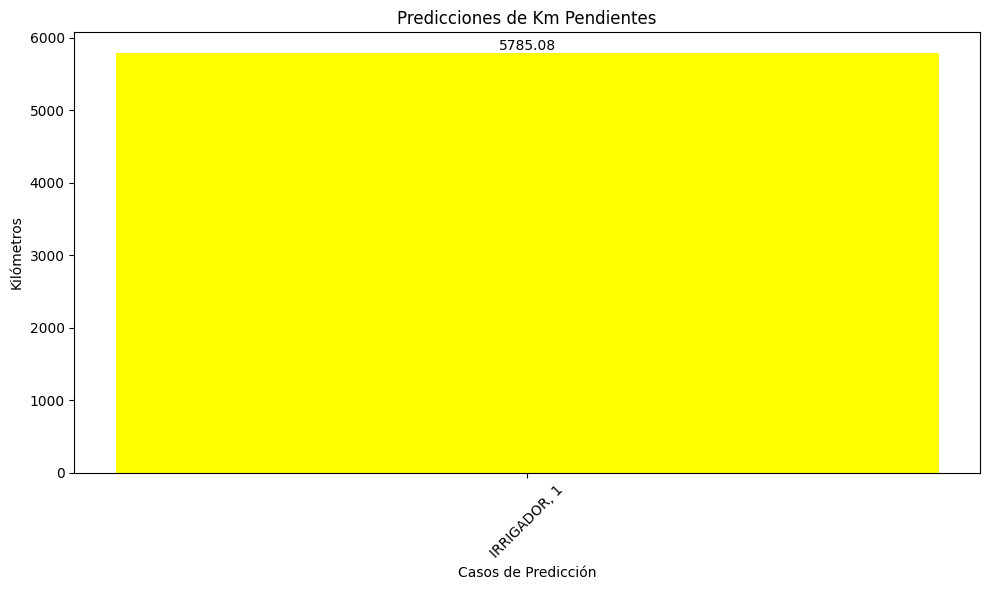

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Cargar datos
# df = pd.read_csv('tu_archivo.csv')

# Renombrar columnas para evitar espacios y caracteres especiales
df.rename(columns={
    'Ult Km/Hr': 'Ult_Km',
    'Km/ Hr Plan': 'Km_Plan',
    'Km/Hr Cambio': 'Km_Cambio',
    'Dias Pend': 'Dias_Pend',
    'Tipo de Vehiculo': 'Tipo_Vehiculo',
    'Km/Hr Pend': 'Km_Pend'
}, inplace=True)

# Variables numéricas y categóricas
numeric_features = ['Ult_Km', 'Km_Plan', 'Km_Cambio', 'Dias_Pend', 'Progreso']
categorical_features = ['Tipo_Vehiculo']

# Preprocesador
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Modelos base
model1 = ('lr', LinearRegression())
model2 = ('knn', KNeighborsRegressor(n_neighbors=3))

# Pipeline completo
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', VotingRegressor(estimators=[model1, model2]))
])

# Separar datos para entrenamiento
X = df[numeric_features + categorical_features]
y = df['Km_Pend']

# Entrenar modelo
model.fit(X, y)

# Lista para guardar predicciones
resultados = []

print("\n--- SISTEMA DE PREDICCIÓN DE KM PENDIENTES PARA REALIZAR EL PROXIMO MANTENIMIENTO ---")

while True:
    # Selección de tipo de vehículo
    tipos_vehiculo = df['Tipo_Vehiculo'].unique().tolist()
    print("\nElige el tipo de vehículo:")
    for i, tipo in enumerate(tipos_vehiculo, start=1):
        print(f"{i}. {tipo}")
    while True:
        opcion = input(f"Tu opción (1-{len(tipos_vehiculo)}): ")
        if opcion.isdigit() and 1 <= int(opcion) <= len(tipos_vehiculo):
            tipo_vehiculo = tipos_vehiculo[int(opcion) - 1]
            break
        else:
            print("Opción inválida.")

    # Ingreso de Km recorridos
    while True:
        try:
            km_recorridos = float(input("Ingrese los kilómetros recorridos (Ult_Km): "))
            break
        except ValueError:
            print("Ingresa un número válido.")

    # Crear DataFrame de entrada con valores promedio
    input_data = pd.DataFrame([{
        'Ult_Km': km_recorridos,
        'Km_Plan': df['Km_Plan'].mean(),
        'Km_Cambio': df['Km_Cambio'].mean(),
        'Dias_Pend': df['Dias_Pend'].mean(),
        'Progreso': df['Progreso'].mean(),
        'Tipo_Vehiculo': tipo_vehiculo
    }])

    # Predecir
    pred = model.predict(input_data)[0]

    # Transformar entrada para predicciones individuales
    X_transformed = model.named_steps['preprocessor'].transform(input_data)
    pred_lr = model.named_steps['regressor'].estimators_[0].predict(X_transformed)[0]
    pred_knn = model.named_steps['regressor'].estimators_[1].predict(X_transformed)[0]

    # Mostrar resultados
    print(f"\n📈 Predicción de Linear Regression: {pred_lr:.2f}")
    print(f"📊 Predicción de KNN: {pred_knn:.2f}")
    print(f"🧮 Predicción final del VotingRegressor (promedio): {pred:.2f}")

    # Guardar resultados
    resultados.append({
        'Ult_Km': km_recorridos,
        'Tipo_Vehiculo': tipo_vehiculo,
        'Linear Regression': pred_lr,
        'KNN': pred_knn,
        'VotingRegressor': pred
    })

    # ¿Desea continuar?
    continuar = input("\n¿Deseas hacer otra predicción? (s/n): ").strip().lower()
    if continuar != 's':
        break

# Convertir resultados a DataFrame
df_resultados = pd.DataFrame(resultados)

# Mostrar tabla resumen
print("\n--- RESUMEN DE PREDICCIONES ---")
print(df_resultados)

# Visualización de todas las predicciones con valores encima de cada barra
plt.figure(figsize=(10, 6))
for i, row in df_resultados.iterrows():
    etiqueta = f"{row['Tipo_Vehiculo']}, {i+1}"
    valor = row['VotingRegressor']
    plt.bar(etiqueta, valor, color='yellow')
    plt.text(etiqueta, valor + 0.5, f"{valor:.2f}", ha='center', va='bottom', fontsize=10, color='black')
plt.title('Predicciones de Km Pendientes')
plt.ylabel('Kilómetros')
plt.xlabel('Casos de Predicción')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
